### Подключим необходимые библиотеки

In [3]:
from sklearn.preprocessing import FunctionTransformer

from reskit.norms import binar_norm, wbysqdist
from reskit.norms import spectral_norm

from reskit.features import degrees,  pagerank

from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier 
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from reskit.core import Transformer, Pipeliner

import os
import pandas as pd
import numpy as np
import copy

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def orig(x):
    return x

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io
import scipy.sparse
import scipy.stats
from scipy import interp
import time
import networkx as nx
import sys
import igraph as ig

### Функция считывания данных

In [5]:
def get_autism(path_to_read='Data/dti/', distances=True):
    def get_autism_distances(loc_name):
        with open(loc_name, 'r') as f:
            read_data = f.readlines()

        read_data = pd.DataFrame(
            np.array([np.array(item[:-1].split()).astype(int) for item in read_data]))

        return read_data

    def get_distance_matrix(coords):
        if type(coords) == pd.core.frame.DataFrame:
            coords = coords.values
        elif type(coords) != np.ndarray:
            print('Provide either pandas df or numpy array!')
            return -1

        shape = len(coords)
        dist_matrix = np.zeros((shape, shape))
        del shape
        for i in range(len(coords)):
            for j in range(i + 1, len(coords)):
                dist_matrix[i, j] = np.linalg.norm(coords[i, :] - coords[j, :])
                dist_matrix[j, i] = dist_matrix[i, j]
        return dist_matrix

    target_vector = []  # this will be a target vector (diagnosis)
    matrices = []  # this will be a list of connectomes
    all_files = sorted(os.listdir(path_to_read))
    matrix_files = [
        item for item in all_files if 'DTI_connectivity' in item and 'All' not in item]
    distance_files = [
        item for item in all_files if 'DTI_region_xyz_centers' in item and 'All' not in item]

    # for each file in a sorted (!) list of files:
    for filename in matrix_files:

        A_dataframe = pd.read_csv(
            path_to_read + filename, sep='   ', header=None, engine='python')
        A = A_dataframe.values  # we will use a list of numpy arrays, NOT pandas dataframes
        matrices.append(A)# append a matrix to our list
        if "ASD" in filename:
            target_vector.append(1)
        elif "TD" in filename:
            target_vector.append(0)
    asd_dict = {}
    asd_dict['X'] = np.array(matrices)
    asd_dict['y'] = np.array(target_vector)
    if distances:
        dist_matrix_list = []
        for item in distance_files:
            # print(item)
            cur_coord = get_autism_distances(path_to_read + item)
            cur_dist_mtx = get_distance_matrix(cur_coord)
            dist_matrix_list += [cur_dist_mtx]

        asd_dict['dist'] = np.array(dist_matrix_list)

    return asd_dict


## Посмотрим на один граф ваочию

In [6]:
path = 'Data/dti/'
data = get_autism(path)

In [7]:
X = data['X']
y = data['y'] 
print X.shape, y.shape

(94, 264, 264) (94,)


In [9]:
A = X[0]

In [12]:
G = ig.Graph.Weighted_Adjacency(list(A), mode="UNDIRECTED", attr="weight", loops=False)

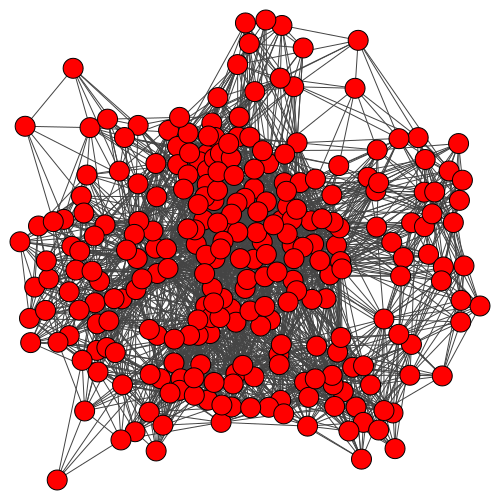

In [34]:
ig.plot(G, bbox=(0,0,500,500), size = 1)

## Произведем зашумление данных

Выберем рандомное ребро с весом $w$. После чего надо добавить к нему $w'$, которое будет браться из нормального распределения $N(w, 1)$

In [ ]:
import random

In [ ]:
def noise_matrix(data, num_noise = 10, sigma = 1):
    list_of_matrices = data['X']
    list_of_predict  = data['y']
    
    shape = list_of_matrices.shape
    loc1 = random.randint(0, shape[0] - 1)
    X_new = copy.copy(list_of_matrices[loc1])
    y_new = copy.copy(list_of_predict[loc1])
    y_new = np.array(y_new)
    y_new = y_new.reshape(1, )
    for i in range(num_noise):
        loc2 = random.randint(0, shape[1] - 1), random.randint(0, shape[2] - 1)
        loc2_inv = loc2[1], loc2[0]
        loc = loc1, loc2[0], loc2[1]
        w = list_of_matrices[loc]
        if (w != 0):
            X_new[loc2] = random.normalvariate(w, sigma)
            X_new[loc2_inv] = X_new[loc2]
        else:
            X_new[loc2] = abs(random.normalvariate(w, sigma))
            X_new[loc2_inv] = X_new[loc2]
    
    X_new = np.array([X_new])
    list_of_matrices = np.vstack([list_of_matrices, X_new])
    list_of_predict = np.hstack([list_of_predict, y_new])
    
    data['X'] = list_of_matrices
    data['y'] = list_of_predict
    
    #print loc1, loc2, X_new
    return data

In [ ]:
for i in range(1000):
    noise_matrix(data, num_noise=20)

In [ ]:
print data['X'].shape
print data['y'].shape